In [1]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as norm
import sqlite3 as sql
import pandas as pd
import seaborn as sns
import dataframe_image as dfi
from functools import reduce
from datetime import datetime, timedelta
from scipy.stats import f_oneway

# Connecting the Database (Contains: Planes, Years (1998 - 2007), Airports, Carriers)
conn = sql.connect('FlightStats.db')
c = conn.cursor()

# PART 2A
Expected Delay based on the time of the day

In [2]:
# SQL Querry to find Expected Delay based on time of the day
c.execute('''
WITH PartofDay AS (
    SELECT
        Year,
        CASE
            WHEN TIME >= 500 AND TIME < 1200 THEN 'Morning'
            WHEN TIME >= 1200 AND TIME < 1700 THEN 'Afternoon'
            WHEN TIME >= 1700 AND TIME < 2100 THEN 'Evening'
            ELSE 'Night'
        END AS TimePeriod,
        COUNT(*) AS NumberofFlights
    FROM
        (
            SELECT
                Year,
                DepTime AS Time
            FROM
                flights
            WHERE Cancelled = 0 AND Diverted = 0
        ) AS subquery
    GROUP BY
        Year, TimePeriod
),
DelayedFlights AS (
    SELECT
        Year,
        CASE
            WHEN TIME >= 500 AND TIME < 1200 THEN 'Morning'
            WHEN TIME >= 1200 AND TIME < 1700 THEN 'Afternoon'
            WHEN TIME >= 1700 AND TIME < 2100 THEN 'Evening'
            ELSE 'Night'
        END AS TimePeriod,
        COUNT(*) AS NumberofDelayFlights,
        AVG(DepDelay) AS AverageDelay
    FROM
        (
            SELECT
                Year,
                DepTime AS Time,
                DepDelay
            FROM
                flights
            WHERE Cancelled = 0 AND Diverted = 0 AND DepDelay > 0 
        ) AS subquery
    GROUP BY
        Year, TimePeriod
)
SELECT
    p.Year,
    p.TimePeriod,
    p.NumberofFlights,
    d.NumberofDelayFlights,
    d.AverageDelay,
    (d.NumberofDelayFlights / CAST(p.NumberofFlights AS FLOAT)) * 100 AS Percentage_Chance_of_Delayed_Flights,
    d.AverageDelay * (d.NumberofDelayFlights / CAST(p.NumberofFlights AS FLOAT)) AS ExpectedDelay
FROM 
    PartofDay p
JOIN
    DelayedFlights d ON p.Year = d.Year AND p.TimePeriod = d.TimePeriod
ORDER BY
    p.Year, p.TimePeriod;
''')

parta = c.fetchall()
parta_df = pd.DataFrame(parta, columns=['Year', 'TimePeriod', 'NumberofFlights', 'NumberofDelayFlights', 'AverageDelay', 'Percentage_Chance_of_Delayed_Flights', 'ExpectedDelay'])

print(parta_df.to_string(index=False))

 Year TimePeriod  NumberofFlights  NumberofDelayFlights  AverageDelay  Percentage_Chance_of_Delayed_Flights  ExpectedDelay
 1998  Afternoon          1587184                719288     21.107000                             45.318501       9.565376
 1998    Evening          1230258                623359     27.538471                             50.668965      13.953459
 1998    Morning          2018046                645713     14.868775                             31.996942       4.757553
 1998      Night           391563                218975     48.286334                             55.923312      27.003317
 1999  Afternoon          1612660                721505     22.309642                             44.740057       9.981346
 1999    Evening          1256192                624739     30.078071                             49.732764      14.958656
 1999    Morning          2081812                618480     16.076011                             29.708735       4.775979
 1999      Night

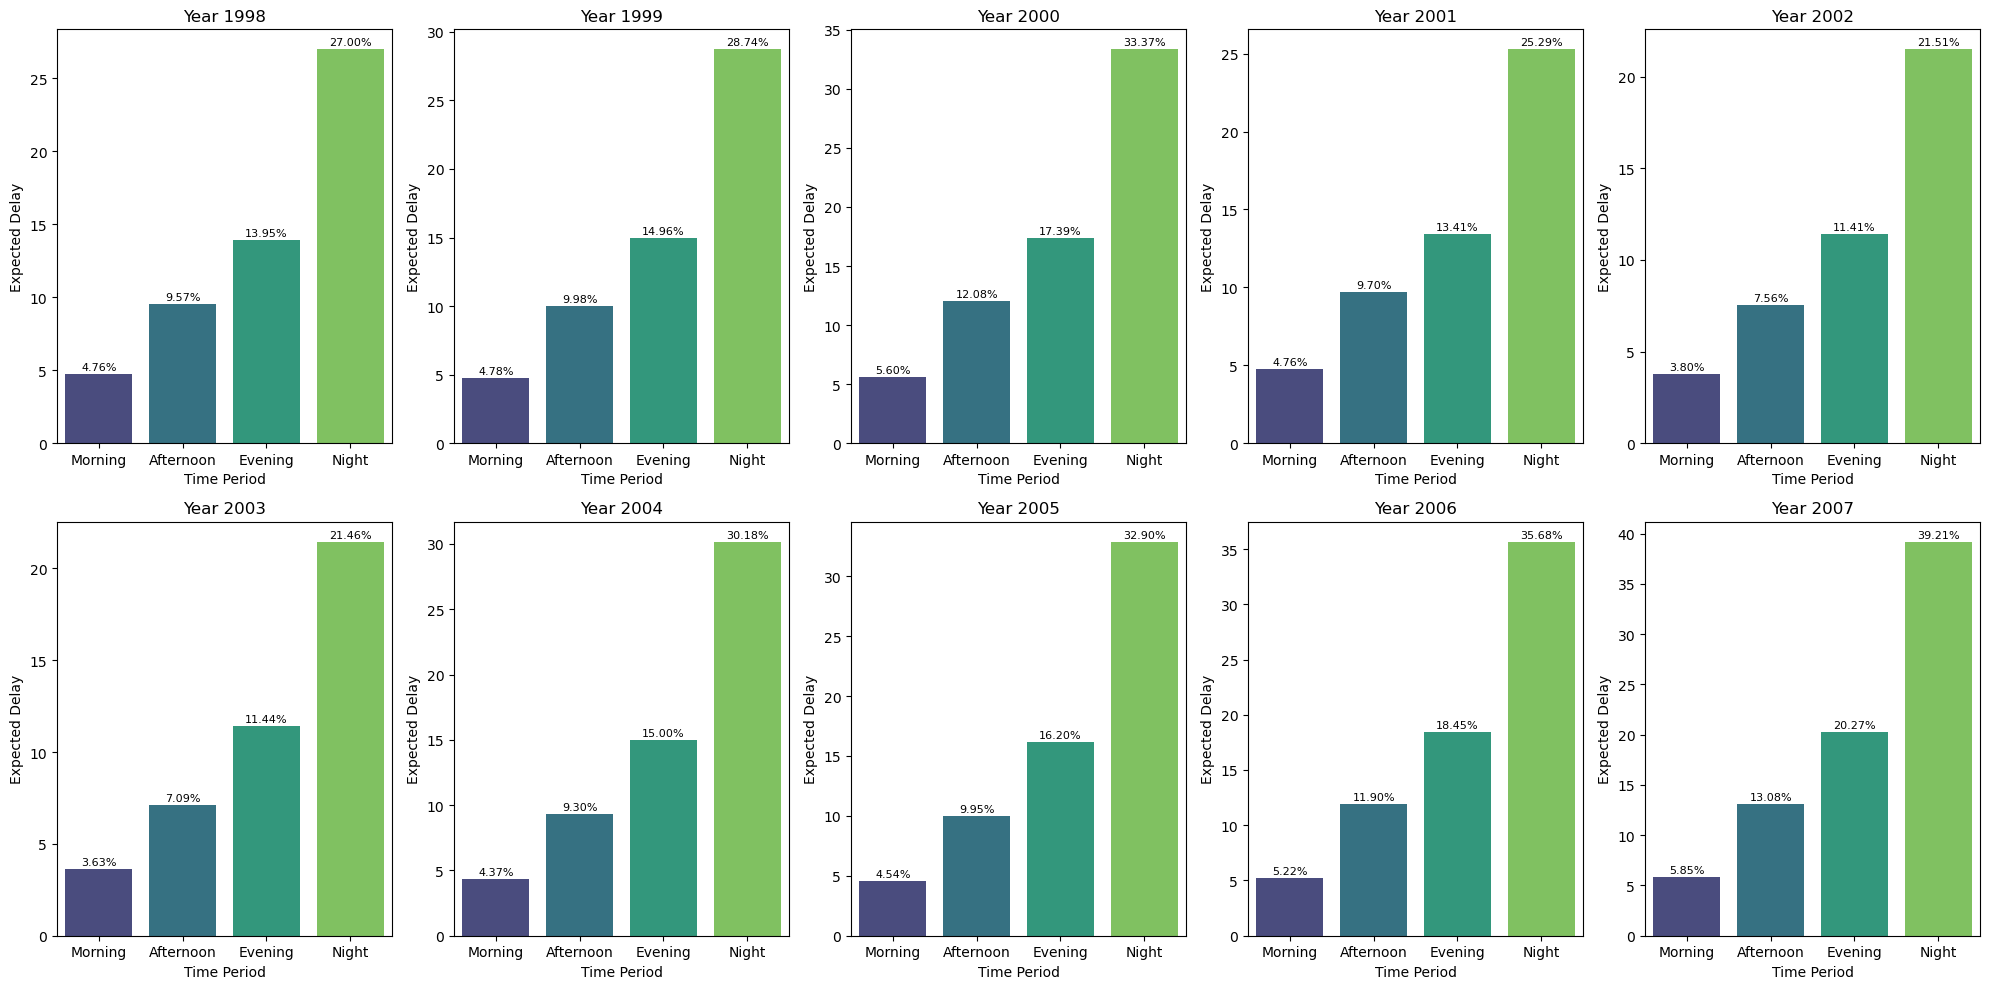

In [3]:
# Defining time period order
time_period_order = ['Morning', 'Afternoon', 'Evening', 'Night']

# Get unique years from the dataset
unique_years = parta_df['Year'].unique()

# Calculate number of rows and columns
num_rows = 2
num_columns = 5

# Set up subplots with 2 rows and 5 columns
fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(20, 10))

# Flatten the axes array to iterate over subplots
axes = axes.flatten()

# Iterate over unique years and create a bar plot for each year
for i, year in enumerate(unique_years):
    # Filter data for the current year
    year_data = parta_df[parta_df['Year'] == year]
    
    # Plot bar graph for the current year
    sns.barplot(data=year_data, x='TimePeriod', y='ExpectedDelay', palette='viridis', ax=axes[i], order=time_period_order)
    
    # Annotate each bar with its specific value
    for p in axes[i].patches:
        axes[i].annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                        textcoords='offset points')
    
    # Set title and labels
    axes[i].set_title(f'Year {year}')
    axes[i].set_xlabel('Time Period')
    axes[i].set_ylabel('Expected Delay')

# Hide the empty subplots
for j in range(len(unique_years), num_rows * num_columns):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

# PART 2A
Expected Delay based on the day of the week

In [4]:
# SQL Querry to find Expected Delay based on the day of the week
c.execute('''
WITH FlightsPerDayOfWeek AS (
    SELECT 
        CASE
            WHEN DayofWeek = 1 THEN 'Mon' 
            WHEN DayofWeek = 2 THEN 'Tue'
            WHEN DayofWeek = 3 THEN 'Wed'
            WHEN DayofWeek = 4 THEN 'Thu'
            WHEN DayofWeek = 5 THEN 'Fri'
            WHEN DayofWeek = 6 THEN 'Sat'
            WHEN DayofWeek = 7 THEN 'Sun'
        END AS DayofWeek,
        Year,
        COUNT(*) AS NumberofFlights,
        AVG(DepDelay) AS AverageDelay,
        SUM(CASE WHEN DepDelay > 0 THEN 1 ELSE 0 END) AS NumberofDelayFlights
    FROM flights
    WHERE Cancelled = 0 AND Diverted = 0
    GROUP BY Year, DayofWeek
)
SELECT
    DayofWeek,
    Year,
    NumberofFlights,
    NumberofDelayFlights,
    AverageDelay,
    ((NumberofDelayFlights / CAST(NumberofFlights AS FLOAT)) * 100) AS Percentage_Chance_of_Delayed_Flights,
    AverageDelay * ((NumberofDelayFlights / CAST(NumberofFlights AS FLOAT)) * 100) / 100 AS ExpectedDelay
FROM FlightsPerDayOfWeek
ORDER BY Year, DayofWeek;
''')

parta2 = c.fetchall()
parta2_df = pd.DataFrame(parta2, columns=['DayofWeek', 'Year', 'NumberofFlights', 'NumberofDelayFlights', 'AverageDelay', 'Percentage_Chance_of_Delayed_Flights',  'ExpectedDelay'])

print(parta2_df.to_string(index=False))

DayofWeek  Year  NumberofFlights  NumberofDelayFlights  AverageDelay  Percentage_Chance_of_Delayed_Flights  ExpectedDelay
      Fri  1998           761774                364271     11.092294                             47.818776       5.304199
      Mon  1998           761314                312508      8.590256                             41.048503       3.526171
      Sat  1998           677223                262740      7.131672                             38.796674       2.766851
      Sun  1998           728289                325120      9.253851                             44.641619       4.131069
      Thu  1998           773397                349273     10.064050                             45.160894       4.545015
      Tue  1998           761553                288842      8.187730                             37.928023       3.105444
      Wed  1998           763501                304581      8.244767                             39.892679       3.289058
      Fri  1999         

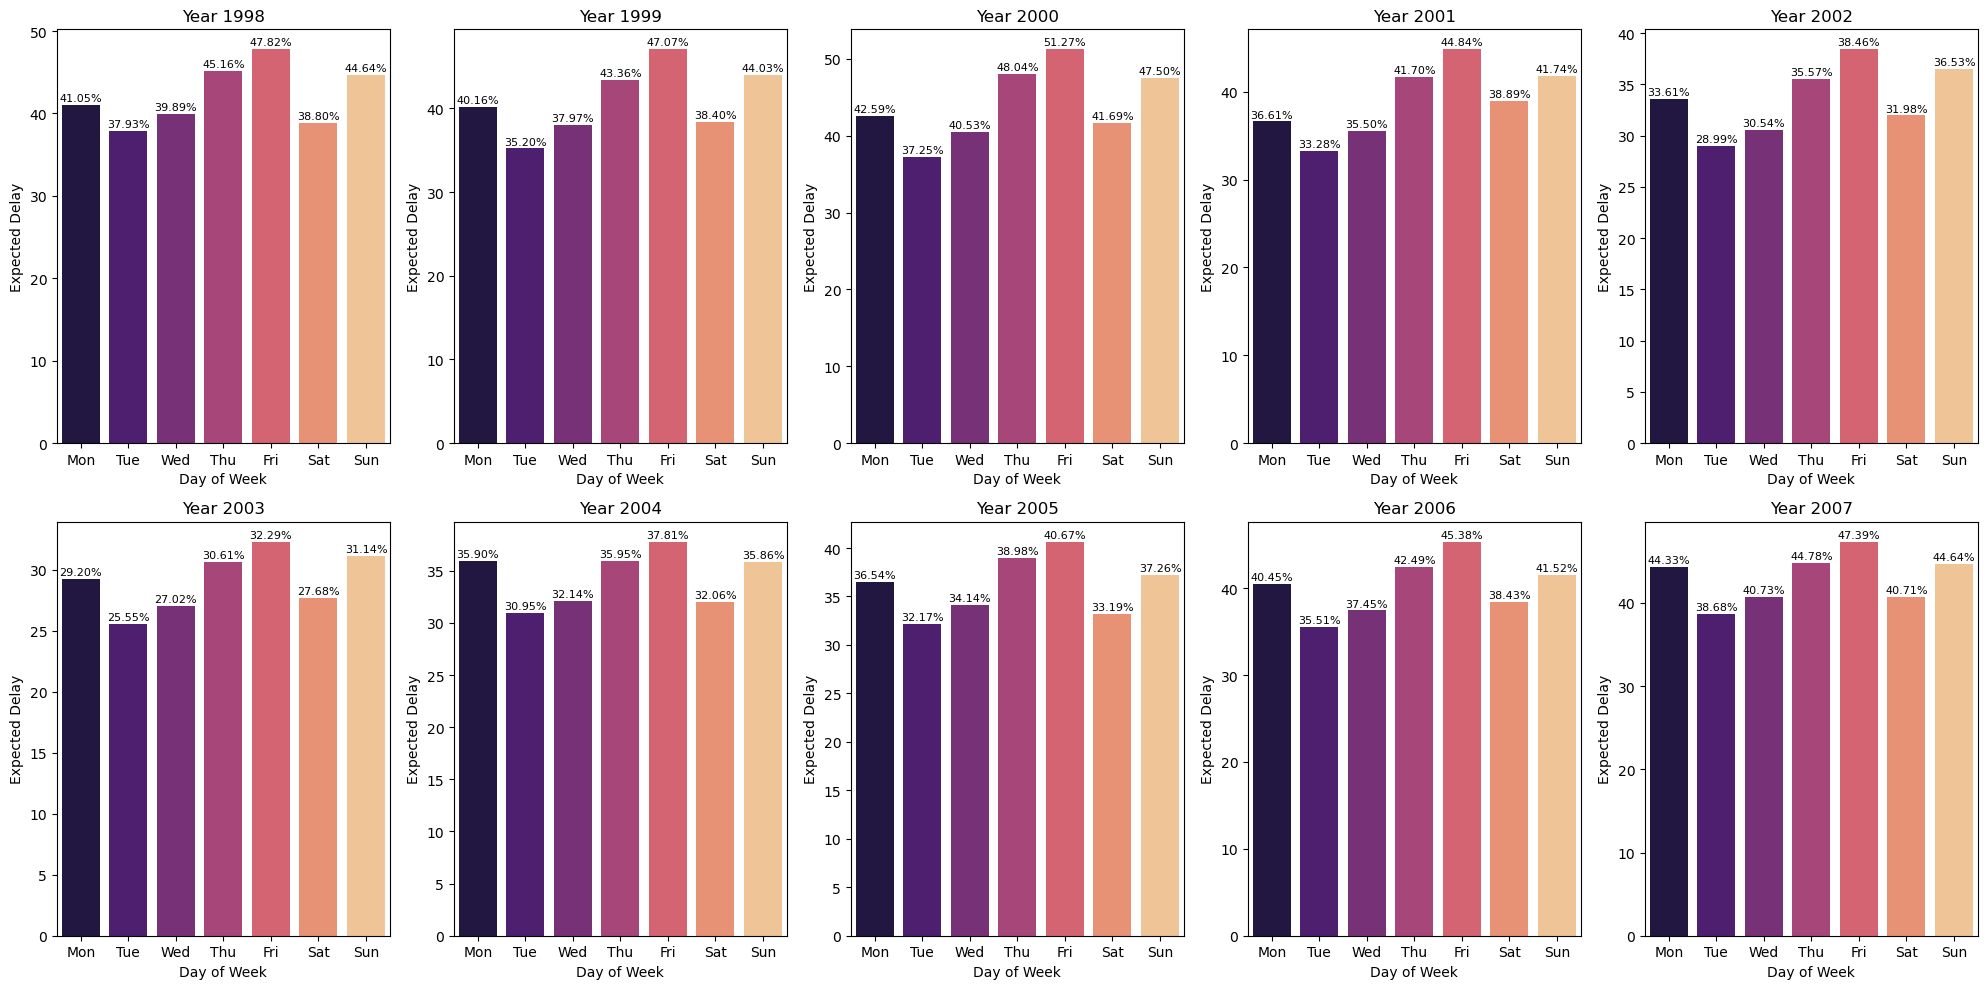

In [5]:
# Defining day order
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Calculate number of rows and columns for subplots
num_rows = 2
num_columns = 5

# Create subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 10))

# Flatten the axes array to iterate over subplots
axes = axes.flatten()

# Iterate over each year and create a bar graph
for i, (year, data) in enumerate(parta2_df.groupby('Year')):
    # Plot bar graph for the current year
    sns.barplot(data=data, x='DayofWeek', y='Percentage_Chance_of_Delayed_Flights', palette='magma', ax=axes[i], order=day_order)
    
    # Annotate each bar with its specific value
    for p in axes[i].patches:
        axes[i].annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')
    
    # Set title and labels
    axes[i].set_title(f'Year {year}')
    axes[i].set_xlabel('Day of Week')
    axes[i].set_ylabel('Expected Delay')

# Hide empty subplots
for j in range(len(parta2_df['Year'].unique()), num_rows * num_columns):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

# PART 2B

In [6]:
# Only run this once to change Year to INTERGER
# # Rename the existing table
# c.execute('''ALTER TABLE "planes" RENAME TO plane_data_old''')

# # Create a new table with the desired schema
# c.execute('''CREATE TABLE "planes" (
#              tailnum TEXT,
#              type TEXT,
#              manufacturer TEXT,
#              issue_date TEXT,
#              model TEXT,
#              status TEXT,
#              aircraft_type TEXT,
#              engine_type TEXT,
#              Year INTEGER)''')

# # Copy data from the old table to the new table
# c.execute('''INSERT INTO "planes" (tailnum, type, manufacturer, issue_date, model, status, aircraft_type, engine_type, Year)
#              SELECT tailnum, type, manufacturer, issue_date, model, status, aircraft_type, engine_type, CAST(Year AS INTEGER)
#              FROM plane_data_old''')

# # Drop the old table
# c.execute('''DROP TABLE plane_data_old''')

# # Commit the changes
# conn.commit()

In [7]:
# SQL Querry to find Expected Delay based on Plane Condition
c.execute('''
WITH FlightsPerPlane AS (
    SELECT
        CASE
            WHEN planes.year < 1998 THEN 'Old'
            ELSE 'New'
        END AS PlaneCondition,
        flights.Year,
        COUNT(*) AS NumberofFlights,
        AVG(DepDelay) AS AverageDelay,
        SUM(CASE WHEN DepDelay > 0 THEN 1 ELSE 0 END) AS NumberofDelayFlights
    FROM flights 
    LEFT JOIN planes ON flights.TailNum = planes.TailNum AND planes.year != 'None' AND planes.year != 0
    WHERE Cancelled = 0 AND Diverted = 0
    GROUP BY flights.Year, PlaneCondition
)
SELECT
    Year,
    PlaneCondition,
    NumberofFlights,
    NumberofDelayFlights,
    AverageDelay,
    (NumberofDelayFlights / CAST(NumberofFlights AS FLOAT)) * 100 AS Percentage_Chance_of_Delayed_Flights,
    AverageDelay * (NumberofDelayFlights / CAST(NumberofFlights AS FLOAT)) AS ExpectedDelay
FROM FlightsPerPlane
ORDER BY Year, PlaneCondition;
''')

partb = c.fetchall()
partb = pd.DataFrame(partb, columns=['Year', 'PlaneCondition', 'NumberofFlights', 'NumberofDelayFlights', 'AverageDelay', 'Percentage_Chance_of_Delayed_Flights', 'ExpectedDelay'])

print(partb.to_string(index=False))

 Year PlaneCondition  NumberofFlights  NumberofDelayFlights  AverageDelay  Percentage_Chance_of_Delayed_Flights  ExpectedDelay
 1998            New          3481351               1412209      9.051713                             40.564970       3.671825
 1998            Old          1745700                795126      8.799054                             45.547689       4.007766
 1999            New          3596107               1454230      9.604310                             40.439008       3.883888
 1999            Old          1763911                738650      8.608666                             41.875696       3.604939
 2000            New          3731617               1608947     11.232834                             43.116617       4.843218
 2000            Old          1749686                811216     11.146825                             46.363519       5.168060
 2001            New          5593391               2192397      8.188087                             39.196205

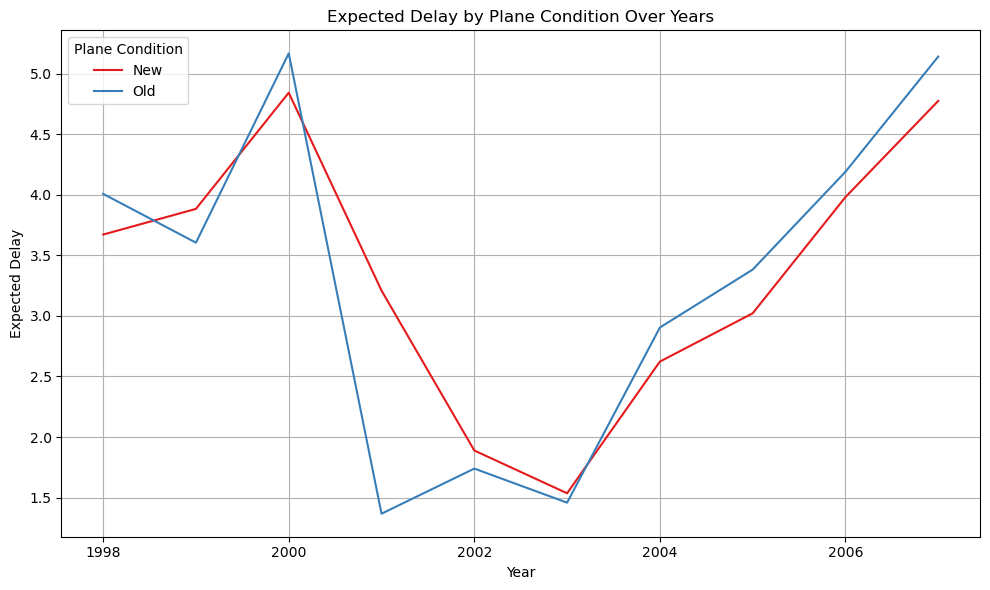

In [8]:
# Convert PlaneCondition to categorical data
partb['PlaneCondition'] = pd.Categorical(partb['PlaneCondition'])

# Plot the lineplot
plt.figure(figsize=(10, 6))
sns.lineplot(data=partb, x='Year', y='ExpectedDelay', hue='PlaneCondition', palette='Set1')

# Add title and labels
plt.title('Expected Delay by Plane Condition Over Years')
plt.xlabel('Year')
plt.ylabel('Expected Delay')

# Show the legend
plt.legend(title='Plane Condition')

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
# Extract data for each plane condition
old_plane_delay = partb[partb['PlaneCondition'] == 'Old']['ExpectedDelay']
new_plane_delay = partb[partb['PlaneCondition'] == 'New']['ExpectedDelay']

# Perform ANOVA test
f_statistic, p_value = f_oneway(old_plane_delay, new_plane_delay)

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("Reject null hypothesis: Plane condition significantly affects delay.")
else:
    print("Fail to reject null hypothesis: Plane condition does not significantly affect delay.")

Fail to reject null hypothesis: Plane condition does not significantly affect delay.
